<a href="https://colab.research.google.com/github/farhanwadia/EEGVisualization/blob/in_progress/EEG_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG Data Analysis

## 1. Clone the GitHub Repository

In [1]:
!git clone https://github.com/farhanwadia/EEGVisualization
!cd EEGVisualization && git checkout in_progress

Cloning into 'EEGVisualization'...
remote: Enumerating objects: 2169, done.
remote: Counting objects: 100% (2169/2169), done.
remote: Compressing objects: 100% (2166/2166), done.
remote: Total 7372 (delta 4), reused 2164 (delta 3), pack-reused 5203
Receiving objects: 100% (7372/7372), 3.15 GiB | 22.01 MiB/s, done.
Resolving deltas: 100% (385/385), done.
Checking out files: 100% (6415/6415), done.
Branch 'in_progress' set up to track remote branch 'in_progress' from 'origin'.
Switched to a new branch 'in_progress'


Change the working directory to EEGVisualization

In [2]:
%cd EEGVisualization
!pwd

/content/EEGVisualization
/content/EEGVisualization


### Imports

In [3]:
!pip install mne

import numpy as np
import os
import mne
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn import svm
from sklearn.neural_network import MLPClassifier

import csv
import json
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

     |████████████████████████████████| 6.9MB 9.0MB/s 


## 2. Split data into training and validation sets

In [4]:
def loadCSV(filename):
    # Takes in a string of the csv file name where the EEG data is (# of measurements by 4 channels)
    # Returns the data as an np array, transposed, with all values /10**6
    data = np.loadtxt(filename, delimiter=',')
    data = data.T / 10**6
    return data

def jsonToNp(pathToJSON):
    with open(pathToJSON, "r") as f:
        data = np.array(json.load(f))
    return data 

def getFiles(parentPath):
    # Returns all files in the folder and its subfolders as a list
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(parentPath):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    return listOfFiles

def createDataset(openFiles, closedFiles):
    n = len(openFiles) + len(closedFiles)
    w = loadCSV(openFiles[0]).shape[0]
    h = loadCSV(openFiles[0]).shape[1]

    X = np.zeros((n, w, h))
    y = np.zeros((n))
    filenames = []

    # Put files into np arrays. 
    #Assumes all data has already been cut to correct lengths, with no inconsistincies in the numper of data points between files
    i = 0
    for lst in [openFiles, closedFiles]:
        for file in lst:
            data = loadCSV(file)
            X[i] = data
            if lst == openFiles:
                y[i] = 1            #Label 1: Open
            else:
                y[i] = 0            #Label 0: Closed

            name = file.split(r"\\")[-1].split(".")[0]
            filenames.append(name)
            i = i+1
    return X, y, filenames

def createDatasetFromJSON(openFiles, closedFiles):
    n = len(openFiles) + len(closedFiles)
    c = jsonToNp(openFiles[0]).shape[0]
    h = jsonToNp(openFiles[0]).shape[1]
    w = jsonToNp(openFiles[0]).shape[2]

    X = np.zeros((n, c, h, w))
    y = np.zeros((n))
    filenames = []
    
    # Put files into np arrays.
    i = 0
    for lst in [openFiles, closedFiles]:
        for file in lst:
            data = jsonToNp(file)
            X[i] = data
            if lst == openFiles:
                y[i] = 1            #Label 1: Open
            else:
                y[i] = 0            #Label 0: Closed

            name = file.split(r"\\")[-1].split(".")[0]
            filenames.append(name)
            i = i+1
    return X, y, filenames


def shuffleDataset(X, y, filenames):
    indices = np.arange(X.shape[0])
    seed = 21 
    np.random.seed(seed)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    filenames = np.array(filenames)
    filenames = filenames[indices]
    return X, y, filenames

def splitDataset(X, y, filenames, percent_train):
    n = X.shape[0]
    X_train = X[:int(percent_train*n)]
    X_val = X[int(percent_train*n):]
    y_train = y[:int(percent_train*n)]
    y_val = y[int(percent_train*n):]
    filenames_train = filenames[:int(percent_train*n)]
    filenames_val = filenames[int(percent_train*n):]
    return X_train, y_train, filenames_train, X_val, y_val, filenames_val

### Time Series

#### 5s

In [5]:
openPath = os.getcwd() + r"//Butterworth Filtered (Valve)//OPEN//"
closedPath = os.getcwd() + r"//Butterworth Filtered (Valve)//CLOSE//"
openFiles = getFiles(openPath)
closedFiles = getFiles(closedPath) 

X, y, filenames = createDataset(openFiles, closedFiles)
X, y, filenames = shuffleDataset(X, y, filenames)
X_train, y_train, filenames_train, X_val, y_val, filenames_val = splitDataset(X, y, filenames, percent_train=0.8)

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_val Shape: ", X_val.shape)
print("y_val Shape: ", y_val.shape)

X_train Shape:  (132, 4, 1280)
y_train Shape:  (132,)
X_val Shape:  (33, 4, 1280)
y_val Shape:  (33,)


#### 2 x 3.5s

In [6]:
openPath = os.getcwd() + r"//Filtered and Cut to 2 Recordings (Valve)//OPEN//"
closedPath = os.getcwd() + r"//Filtered and Cut to 2 Recordings (Valve)//CLOSE//"
openFiles = getFiles(openPath)
closedFiles = getFiles(closedPath) 

X, y, filenames = createDataset(openFiles, closedFiles)
X, y, filenames = shuffleDataset(X, y, filenames)
X2_train, y2_train, filenames2_train, X2_val, y2_val, filenames2_val = splitDataset(X, y, filenames, percent_train=0.8)

print("X2_train Shape: ", X2_train.shape)
print("y2_train Shape: ", y2_train.shape)
print("X2_val Shape: ", X2_val.shape)
print("y2_val Shape: ", y2_val.shape)

X2_train Shape:  (264, 4, 896)
y2_train Shape:  (264,)
X2_val Shape:  (66, 4, 896)
y2_val Shape:  (66,)


### Frequency Domain

In [7]:
openPath = os.getcwd() + r"//Butterworth Filtered (Valve)//FFTs//OPEN//"
closedPath = os.getcwd() + r"//Butterworth Filtered (Valve)//FFTs//CLOSE//"
openFiles = getFiles(openPath)
closedFiles = getFiles(closedPath) 

X, y, filenames = createDataset(openFiles, closedFiles)
X, y, filenames = shuffleDataset(X, y, filenames)
X = X[:, 1:, :] #Remove first column in 2nd dimension (contained x-axis frequencies for plotting)
X_train_f, y_train_f, filenames_train_f, X_val_f, y_val_f, filenames_val_f = splitDataset(X, y, filenames, percent_train=0.8)

print("X_train_f Shape: ", X_train_f.shape)
print("y_train_f Shape: ", y_train_f.shape)
print("X_val_f Shape: ", X_val_f.shape)
print("y_val_f Shape: ", y_val_f.shape)

X_train_f Shape:  (132, 4, 250)
y_train_f Shape:  (132,)
X_val_f Shape:  (33, 4, 250)
y_val_f Shape:  (33,)


### Time-Frequency

In [8]:
openPath = os.getcwd() + r"//Butterworth Filtered (Valve)//Spectogram//OPEN//"
closedPath = os.getcwd() + r"//Butterworth Filtered (Valve)//Spectogram//CLOSE//"
openFiles = getFiles(openPath)
closedFiles = getFiles(closedPath)

X, y, filenames = createDatasetFromJSON(openFiles, closedFiles)
X, y, filenames = shuffleDataset(X, y, filenames)
X_train_tf, y_train_tf, filenames_train_tf, X_val_tf, y_val_tf, filenames_val_tf = splitDataset(X, y, filenames, percent_train=0.8)

print("X_train_tf Shape: ", X_train_tf.shape)
print("y_train_tf Shape: ", y_train_tf.shape)
print("X_val_tf Shape: ", X_val_tf.shape)
print("y_val_tf Shape: ", y_val_tf.shape)

X_train_tf Shape:  (132, 4, 100, 1280)
y_train_tf Shape:  (132,)
X_val_tf Shape:  (33, 4, 100, 1280)
y_val_tf Shape:  (33,)


In [9]:
openPath = os.getcwd() + r"//Butterworth Filtered (Valve)//Spectogram Power//OPEN//"
closedPath = os.getcwd() + r"//Butterworth Filtered (Valve)//Spectogram Power//CLOSE//"
openFiles = getFiles(openPath)
closedFiles = getFiles(closedPath)

X, y, filenames = createDatasetFromJSON(openFiles, closedFiles)
X, y, filenames = shuffleDataset(X, y, filenames)
X_train_tfp, y_train_tfp, filenames_train_tfp, X_val_tfp, y_val_tfp, filenames_val_tfp = splitDataset(X, y, filenames, percent_train=0.8)

print("X_train_tfp Shape: ", X_train_tfp.shape)
print("y_train_tfp Shape: ", y_train_tfp.shape)
print("X_val_tfp Shape: ", X_val_tfp.shape)
print("y_val_tfp Shape: ", y_val_tfp.shape)

X_train_tfp Shape:  (132, 4, 100, 1280)
y_train_tfp Shape:  (132,)
X_val_tfp Shape:  (33, 4, 100, 1280)
y_val_tfp Shape:  (33,)


## 3. Baseline Models
As a baseline, try using a linear SVM and some non-linear SVMs with different amounts of regularization to try and classify the data

In [10]:
def get_accuracy_svm(model, X, y):
    predictions = model.predict(X)
    num_correct = np.sum((predictions - y) == 0)
    n = X.shape[0]
    accuracy = num_correct/n
    print("The number of correct predictions is: ", num_correct)
    print("The number of files is: ", n)
    print("The accuracy is: ", accuracy)

### Time Series

#### 5s

In [11]:
# Stack channels and datapoints into one dimension for sklearn to work
X_train_svm = X_train.reshape(X_train.shape[0], 4*(256*5))
X_val_svm = X_val.reshape(X_val.shape[0], 4*(256*5))

# Fit the models
# Nonlinear model 1 has a higher regularization (1) than model 2 (1/10)
# Higher regularization helps to increase variance and reduce overfitting   
model_linear = svm.LinearSVC()
model_linear.fit(X_train_svm, y_train)

model_nonlinear_1 = svm.SVC(kernel='sigmoid')
model_nonlinear_1.fit(X_train_svm, y_train)

model_nonlinear_2 = svm.SVC(kernel='sigmoid', C=10)
model_nonlinear_2.fit(X_train_svm, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

##### Linear Model

Linear Model 

Training Accuracy
The number of correct predictions is:  67
The number of files is:  132
The accuracy is:  0.5075757575757576

Validation Accuracy
The number of correct predictions is:  19
The number of files is:  33
The accuracy is:  0.5757575757575758
The shape of the coefficients vector is:  (5120,)
The intercept of the hyperplane is:  [-0.01507717] 



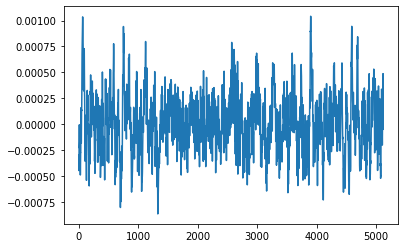

In [12]:
# Linear model accuracies
print("Linear Model \n")
print("Training Accuracy")
get_accuracy_svm(model_linear, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_linear, X_val_svm, y_val)

# Linear model coefficients
coefs = model_linear.coef_[0]
intercept = model_linear.intercept_
#print("The coefficients of the hyperplane are: ", coefs)
print("The shape of the coefficients vector is: ", coefs.shape)
print("The intercept of the hyperplane is: ", intercept, "\n")

#Plot the coefficients of the linear SVM
x = np.array(range(1, len(coefs)+1))
plt.plot(x, coefs)
plt.show()

##### Non-Linear Models

In [13]:
#Non-Linear Model 1 Accuracies
print("\nNon-Linear Model 1 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_1, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_1, X_val_svm, y_val)

#Non-Linear Model 2 Accuracies
print("\nNon-Linear Model 2 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_2, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_2, X_val_svm, y_val)


Non-Linear Model 1 

Training Accuracy
The number of correct predictions is:  100
The number of files is:  132
The accuracy is:  0.7575757575757576

Validation Accuracy
The number of correct predictions is:  18
The number of files is:  33
The accuracy is:  0.5454545454545454

Non-Linear Model 2 

Training Accuracy
The number of correct predictions is:  117
The number of files is:  132
The accuracy is:  0.8863636363636364

Validation Accuracy
The number of correct predictions is:  18
The number of files is:  33
The accuracy is:  0.5454545454545454


#### 2 x 3.5s

In [17]:
# Stack channels and datapoints into one dimension for sklearn to work
X_train_svm = X2_train.reshape(X2_train.shape[0], 4*int(256*3.5))
X_val_svm = X2_val.reshape(X2_val.shape[0], 4*int(256*3.5))

# Fit the models
# Nonlinear model 1 has a higher regularization (1) than model 2 (1/10)
# Higher regularization helps to increase variance and reduce overfitting   
model_linear = svm.LinearSVC()
model_linear.fit(X_train_svm, y2_train)

model_nonlinear_1 = svm.SVC(kernel='sigmoid')
model_nonlinear_1.fit(X_train_svm, y2_train)

model_nonlinear_2 = svm.SVC(kernel='sigmoid', C=10)
model_nonlinear_2.fit(X_train_svm, y2_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

##### Linear Model

Linear Model 

Training Accuracy
The number of correct predictions is:  154
The number of files is:  264
The accuracy is:  0.5833333333333334

Validation Accuracy
The number of correct predictions is:  25
The number of files is:  66
The accuracy is:  0.3787878787878788
The shape of the coefficients vector is:  (3584,)
The intercept of the hyperplane is:  [3.38546291e-06] 



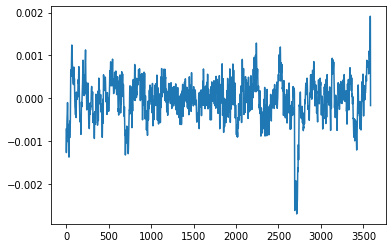

In [19]:
# Linear model accuracies
print("Linear Model \n")
print("Training Accuracy")
get_accuracy_svm(model_linear, X_train_svm, y2_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_linear, X_val_svm, y2_val)

# Linear model coefficients
coefs = model_linear.coef_[0]
intercept = model_linear.intercept_
#print("The coefficients of the hyperplane are: ", coefs)
print("The shape of the coefficients vector is: ", coefs.shape)
print("The intercept of the hyperplane is: ", intercept, "\n")

#Plot the coefficients of the linear SVM
x = np.array(range(1, len(coefs)+1))
plt.plot(x, coefs)
plt.show()

##### Non-Linear Models

In [20]:
#Non-Linear Model 1 Accuracies
print("\nNon-Linear Model 1 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_1, X_train_svm, y2_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_1, X_val_svm, y2_val)

#Non-Linear Model 2 Accuracies
print("\nNon-Linear Model 2 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_2, X_train_svm, y2_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_2, X_val_svm, y2_val)


Non-Linear Model 1 

Training Accuracy
The number of correct predictions is:  183
The number of files is:  264
The accuracy is:  0.6931818181818182

Validation Accuracy
The number of correct predictions is:  33
The number of files is:  66
The accuracy is:  0.5

Non-Linear Model 2 

Training Accuracy
The number of correct predictions is:  188
The number of files is:  264
The accuracy is:  0.7121212121212122

Validation Accuracy
The number of correct predictions is:  34
The number of files is:  66
The accuracy is:  0.5151515151515151


### Frequency Domain

In [ ]:
# Stack channels and datapoints into one dimension for sklearn to work
X_train_svm = X_train_f.reshape(X_train_f.shape[0], 4*(250))
X_val_svm = X_val_f.reshape(X_val_f.shape[0], 4*(250))

# Fit the models
# Nonlinear model 1 has a higher regularization (1) than model 2 (1/10)
# Higher regularization helps to increase variance and reduce overfitting   
model_linear = svm.LinearSVC()
model_linear.fit(X_train_svm, y_train)

model_nonlinear_1 = svm.SVC(kernel='sigmoid')
model_nonlinear_1.fit(X_train_svm, y_train)

model_nonlinear_2 = svm.SVC(kernel='sigmoid', C=10)
model_nonlinear_2.fit(X_train_svm, y_train)

model_nonlinear_3 = svm.SVC(kernel='rbf', C=10)
model_nonlinear_3.fit(X_train_svm, y_train)

#### Linear Model

In [ ]:
# Linear model accuracies
print("Linear Model \n")
print("Training Accuracy")
get_accuracy_svm(model_linear, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_linear, X_val_svm, y_val)

# Linear model coefficients
coefs = model_linear.coef_[0]
intercept = model_linear.intercept_
#print("The coefficients of the hyperplane are: ", coefs)
print("The shape of the coefficients vector is: ", coefs.shape)
print("The intercept of the hyperplane is: ", intercept, "\n")

#Plot the coefficients of the linear SVM
x = np.array(range(1, len(coefs)+1))
plt.plot(x, coefs)
plt.show()

#### Non-Linear Models

In [ ]:
#Non-Linear Model 1 Accuracies
print("\nNon-Linear Model 1 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_1, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_1, X_val_svm, y_val)

#Non-Linear Model 2 Accuracies
print("\nNon-Linear Model 2 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_2, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_2, X_val_svm, y_val)

#Non-Linear Model 3 Accuracies
print("\nNon-Linear Model 3 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_3, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_3, X_val_svm, y_val)

### Comments
Comparing the linear models, the coefficients in the frequency domain seem to repeat in 4 distinct groups which look similar to each other. Since the channels were essentially stacked on top of each other before running the svm, what this suggests is that the svm weights within each individual channel are likely similar.

From the shape, we see that low frequencies have high weight magnitudes assigned to them (whether positive or negative), and that the higher frequencies around 50 Hz have lower magnitude weights. We also see an oscillation of the weights switching direction between positive and negative as they genrally decrease in magnitude for increasing frequencies.

We also see, interestingly, that the lower regularization non-linear model (2) for the frequency domain data has provided the highest accuracy so far of 22/33, but this could be a coincidence since the classification on the training set is only ~50%. 

It is noteworthy that the frequency domain data has provided the highest accuracy so far, since each FFT has fewer points per channel as compared to the time series data (250 vs 1280 points).

## 4. Deep Learning Models

### Training Code

In [21]:
torch.manual_seed(21) # set the random seed

def createTensorDataset(data, labels):
    # Returns a tensor dataset object given np arrays of the data and labels
    data_tensor = torch.tensor(data)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(data_tensor, labels_tensor)
    return dataset

def addDimensionForCNNModels(dataset):
# Takes in a pytorch dataset with data of size [N, C, H]
# Returns a pytorch dataset with data of size [N, 1, C, H]
# This allows us to treat the multiple EEG channnels like a 2D image of 1 channel
    data = dataset.tensors[0]
    labels = dataset.tensors[1]
    data = torch.unsqueeze(data, 1)
    return TensorDataset(data, labels)

def get_accuracy(model, data_loader, train=False, use_cuda=True):
    correct = 0
    total = 0
    for file, labels in iter(data_loader):
        file = file.float()
        labels = labels.long()
        if use_cuda and torch.cuda.is_available():
            file = file.cuda()
            labels = labels.cuda()
        output = model(file)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += file.shape[0]
    return correct / total

def plot_training_curve(iters, losses, train_acc, val_acc):
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Maximum Training Accuracy: {}".format(max(train_acc)))
    print("Maximum Validation Accuracy: {}".format(max(val_acc)))

In [22]:
def train(model, train_dataset, val_dataset, batch_size=100, num_epochs=1, learning_rate=0.01, momen=0.9, use_cuda=True, use_adam=True, save_weights=True):
    # Create folder to save the weights in
    now = datetime.now()
    folder_name = model.name + ' Weights ' + now.strftime("%Y-%m-%d %H-%M")
    save_path = os.getcwd() + "//" + folder_name + "//"
    if save_weights and not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Make dataloader objects to iterate over
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    #Define loss functions and optimizer
    criterion = nn.CrossEntropyLoss()
    if use_adam:
        optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momen)

    iters, losses, train_acc, val_acc = [], [], [], []
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for file, labels in iter(train_loader):
            
            file = file.float()
            labels = labels.long()
            if use_cuda and torch.cuda.is_available():
                file = file.cuda()
                labels = labels.cuda()
            
            out = model(file)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_loader, train=False))  # compute validation accuracy
            print("Iteration: ", str(n), "| Train Loss: ", losses[n], "| Train Accuracy: ", train_acc[n], "| Validation Accuracy: ", val_acc[n])
            n += 1
            model_path = "model_{0}_bs{1}_lr{2}_epoch{3}_iteration{4}_val-acc{5}".format(model.name, 
                                                                                         batch_size, 
                                                                                         str(learning_rate).replace('.', '-'), 
                                                                                         epoch, n, str(round(val_acc[-1]*100, 4)).replace('.', '-'))
            if save_weights:
                if val_acc[-1] == max(val_acc) and val_acc.count(val_acc[-1]) == 1:
                    torch.save(model.state_dict(), save_path + model_path + ".pth") #save weights at new maximum for validation accuracy
    if save_weights:
        torch.save(model.state_dict(), save_path + model_path + ".pth") #Save the very last iteration
        #Write the train loss and train/val accuracies to CSV file
        epochs = np.arange(1, num_epochs + 1)
        np.savetxt(save_path + "{}_train_loss.csv".format(model_path), losses)
        np.savetxt(save_path + "{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt(save_path + "{}_val_acc.csv".format(model_path), val_acc) 

    # plotting
    plot_training_curve(iters, losses, train_acc, val_acc)

### Model Architectures

#### Time Series

In [23]:
class ANN_TS_2L(nn.Module):
    def __init__(self):
        super(ANN_TS_2L, self).__init__()
        self.name = "ANN_TS_2L"
        self.layer1 = nn.Linear((256*5)*4, 200)
        self.layer2 = nn.Linear(200, 50)
        self.layer3 = nn.Linear(50, 2)
    def forward(self, img):
        flattened = img.view(-1, (256*5)*4)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

class ANN_TS2_2L(nn.Module):
    def __init__(self):
        super(ANN_TS2_2L, self).__init__()
        self.name = "ANN_TS2_2L"
        self.layer1 = nn.Linear(int(256*3.5)*4, 200)
        self.layer2 = nn.Linear(200, 50)
        self.layer3 = nn.Linear(50, 2)
    def forward(self, img):
        flattened = img.view(-1, int(256*3.5)*4)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

class ANN_TS_3L(nn.Module):
    def __init__(self):
        super(ANN_TS_3L, self).__init__()
        self.name = "ANN_TS_3L"
        self.layer1 = nn.Linear((256*5)*4, 500)
        self.layer2 = nn.Linear(500, 200)
        self.layer3 = nn.Linear(200, 50)
        self.layer4 = nn.Linear(50, 2)
    def forward(self, img):
        flattened = img.view(-1, (256*5)*4)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = F.relu(self.layer3(activation2))
        output = self.layer4(activation3)
        return output

class CNN_TS(nn.Module):
    def __init__(self):
        super(CNN_TS, self).__init__()
        self.name = "CNN_TS"
        self.conv1 = nn.Conv2d(1, 4, 2) #in_channels, out_channels (# of kernels to try), kernel_size. Size in is 4x1280
        self.pool = nn.MaxPool2d(2, 2) #kernel_size (for the pool), stride. Size in should be 4x2x1278 
        self.conv2 = nn.Conv2d(4, 8, 1) #size in should be 4x1x639 
        #self.pool = nn.MaxPool2d(1, 2) # size in should be 8x1x639
        #self.conv3 = nn.Conv2d(10, 15, 3)
        #self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(639*8, 600)
        self.fc2 = nn.Linear(600, 60)
        self.fc3 = nn.Linear(60, 2)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) #flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        x = x.squeeze(1)
        return x

#### Frequency Domain

In [44]:
class ANN_FD_2L(nn.Module):
    def __init__(self):
        super(ANN_FD_2L, self).__init__()
        self.name = "ANN_FD_2L"
        self.layer1 = nn.Linear((250)*4, 250)
        self.layer2 = nn.Linear(250, 50)
        self.layer3 = nn.Linear(50, 2)
    def forward(self, img):
        flattened = img.view(-1, (250)*4)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

class ANN_FD_3L(nn.Module):
    def __init__(self):
        super(ANN_FD_3L, self).__init__()
        self.name = "ANN_FD_3L"
        self.layer1 = nn.Linear((250)*4, 500)
        self.layer2 = nn.Linear(500, 200)
        self.layer3 = nn.Linear(200, 50)
        self.layer4 = nn.Linear(50, 2)
    def forward(self, img):
        flattened = img.view(-1, (250)*4)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = F.relu(self.layer3(activation2))
        output = self.layer4(activation3)
        return output

#### Time-Frequency

In [45]:
class CNN_TF(nn.Module):
    def __init__(self):
        super(CNN_TF, self).__init__()
        self.name = "CNN_TF"
        
        self.conv1 = nn.Conv2d(4, 8, 4) #in_channels, out_channels (# of kernels to try), kernel_size. Size in is 4x50x640
        self.pool = nn.MaxPool2d(2, 2) #kernel_size (for the pool), stride. Size in should be 8x46x636 
        self.conv2 = nn.Conv2d(8, 16, 4) #size in should be 8x23x318
        self.pool = nn.MaxPool2d(2, 2) # size in should be 16x19x314
        
        self.fc1 = nn.Linear(16*10*157, 2500) #size in should be 16x10x157
        self.fc2 = nn.Linear(2500, 500)
        self.fc3 = nn.Linear(500, 50)
        self.fc4 = nn.Linear(50, 2)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flatten the input

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        x = x.squeeze(1)
        return x

### Training

#### Time Series Models

##### Feedforward Neural Networks

###### 5s

In [36]:
train_dataset = createTensorDataset(X_train, y_train)
val_dataset = createTensorDataset(X_val, y_val)

Iteration:  0 | Train Loss:  0.014009326696395874 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  1 | Train Loss:  0.013866937160491944 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  2 | Train Loss:  0.014033997058868408 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  3 | Train Loss:  0.013990954160690308 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  4 | Train Loss:  0.013860965967178345 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  5 | Train Loss:  0.014014126062393188 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  6 | Train Loss:  0.013975018262863159 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  7 | Train Loss:  0.01385639190673828 | Train Accuracy:  0

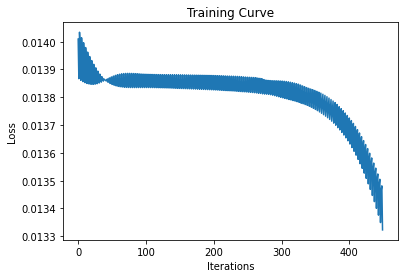

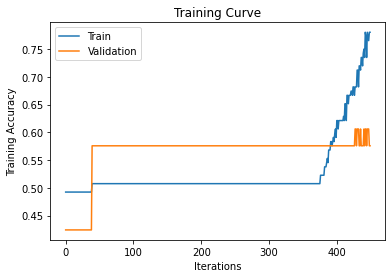

Final Training Accuracy: 0.7803030303030303
Final Validation Accuracy: 0.5757575757575758
Maximum Training Accuracy: 0.7803030303030303
Maximum Validation Accuracy: 0.6060606060606061


In [37]:
model = ANN_TS_2L()
train(model, train_dataset, val_dataset, batch_size = 50, num_epochs=150, learning_rate = 0.0005, momen = 0.7, use_adam = True, save_weights=True)

Iteration:  0 | Train Loss:  0.01393814206123352 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  1 | Train Loss:  0.01384824514389038 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  2 | Train Loss:  0.013946735858917236 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  3 | Train Loss:  0.013918719291687011 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  4 | Train Loss:  0.013846937417984009 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  5 | Train Loss:  0.013924473524093628 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  6 | Train Loss:  0.013901991844177246 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  7 | Train Loss:  0.013847835063934326 | Train Accuracy:  0.

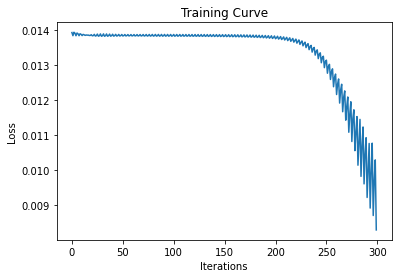

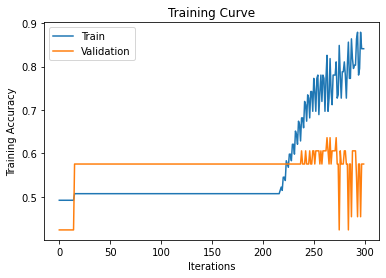

Final Training Accuracy: 0.8409090909090909
Final Validation Accuracy: 0.5757575757575758
Maximum Training Accuracy: 0.8787878787878788
Maximum Validation Accuracy: 0.6363636363636364


In [38]:
model = ANN_TS_3L()
train(model, train_dataset, val_dataset, batch_size = 50, num_epochs=100, learning_rate = 0.0005, momen = 0.6, use_adam = True, save_weights=True)

###### 2 x 3.5s

In [24]:
train_dataset = createTensorDataset(X2_train, y2_train)
val_dataset = createTensorDataset(X2_val, y2_val)

Iteration:  0 | Train Loss:  0.009236644903818767 | Train Accuracy:  0.5 | Validation Accuracy:  0.3939393939393939
Iteration:  1 | Train Loss:  0.009247331619262696 | Train Accuracy:  0.5 | Validation Accuracy:  0.3939393939393939
Iteration:  2 | Train Loss:  0.009237620035807291 | Train Accuracy:  0.5 | Validation Accuracy:  0.3939393939393939
Iteration:  3 | Train Loss:  0.009259612560272216 | Train Accuracy:  0.5 | Validation Accuracy:  0.3939393939393939
Iteration:  4 | Train Loss:  0.009234548409779867 | Train Accuracy:  0.5 | Validation Accuracy:  0.3939393939393939
Iteration:  5 | Train Loss:  0.009246983528137208 | Train Accuracy:  0.5 | Validation Accuracy:  0.3939393939393939
Iteration:  6 | Train Loss:  0.009238137404123941 | Train Accuracy:  0.5 | Validation Accuracy:  0.3939393939393939
Iteration:  7 | Train Loss:  0.009255282084147136 | Train Accuracy:  0.5 | Validation Accuracy:  0.3939393939393939
Iteration:  8 | Train Loss:  0.00923637866973877 | Train Accuracy:  0.5 

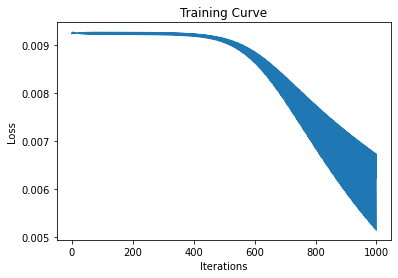

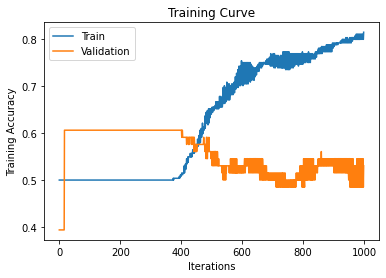

Final Training Accuracy: 0.8143939393939394
Final Validation Accuracy: 0.5303030303030303
Maximum Training Accuracy: 0.8143939393939394
Maximum Validation Accuracy: 0.6060606060606061


In [35]:
model = ANN_TS2_2L()
train(model, train_dataset, val_dataset, batch_size = 75, num_epochs=250, learning_rate = 0.0005, momen = 0.7, use_adam = True, save_weights=True)

##### Convolutional Neural Network

In [39]:
#train_dataset_CNN  = addDimensionForCNNModels(train_dataset)
#val_dataset_CNN  = addDimensionForCNNModels(val_dataset)

Iteration:  0 | Train Loss:  0.013847717046737672 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  1 | Train Loss:  0.017190128564834595 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  2 | Train Loss:  0.013841489553451538 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  3 | Train Loss:  0.014020962715148926 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  4 | Train Loss:  0.013860390186309815 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  5 | Train Loss:  0.01395667314529419 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  6 | Train Loss:  0.01386945605278015 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  7 | Train Loss:  0.013906909227371216 | Train Accuracy:  0.507575

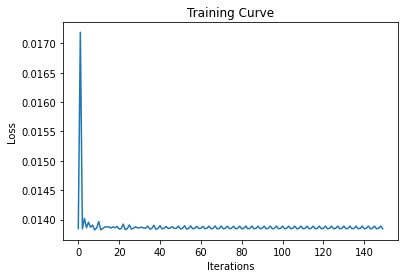

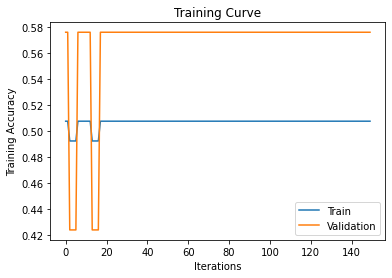

Final Training Accuracy: 0.5075757575757576
Final Validation Accuracy: 0.5757575757575758
Maximum Training Accuracy: 0.5075757575757576
Maximum Validation Accuracy: 0.5757575757575758


In [40]:
#model = CNN_TS()
#train(model, train_dataset_CNN, val_dataset_CNN, batch_size = 50, num_epochs=50, learning_rate = 0.001, momen = 0.6, use_adam = True)

#### Frequency Domain Models

##### Feedforward Neural Networks

In [ ]:
#train_dataset = createTensorDataset(X_train_f, y_train)
#val_dataset = createTensorDataset(X_val_f, y_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration:  0 | Train Loss:  0.013900293111801148 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  1 | Train Loss:  0.01384772539138794 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  2 | Train Loss:  0.01390955686569214 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  3 | Train Loss:  0.013893988132476807 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  4 | Train Loss:  0.013848631381988526 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  5 | Train Loss:  0.013901753425598145 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  6 | Train Loss:  0.013888299465179443 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  7 | Train Loss:  0.013849905729293822 | Train Accuracy:  0.

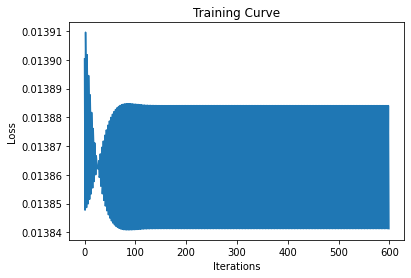

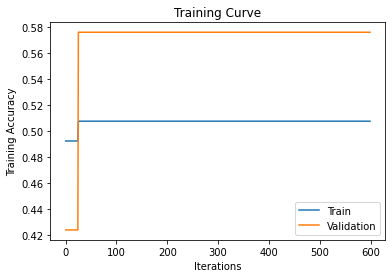

Final Training Accuracy: 0.5075757575757576
Final Validation Accuracy: 0.5757575757575758
Maximum Training Accuracy: 0.5075757575757576
Maximum Validation Accuracy: 0.5757575757575758


In [ ]:
#model = ANN_FD_2L()
#train(model, train_dataset, val_dataset, batch_size = 50, num_epochs=200, learning_rate = 0.0001, momen = 0.7, use_adam = True)

Iteration:  0 | Train Loss:  0.013964571952819825 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  1 | Train Loss:  0.013854398727416992 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  2 | Train Loss:  0.013990055322647094 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  3 | Train Loss:  0.01395804762840271 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  4 | Train Loss:  0.013852859735488892 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  5 | Train Loss:  0.013982472419738769 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  6 | Train Loss:  0.01395189642906189 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  7 | Train Loss:  0.013851521015167236 | Train Accuracy:  0.

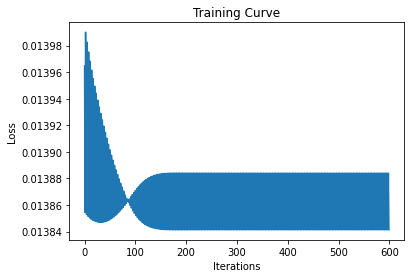

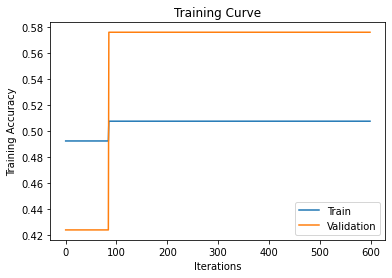

Final Training Accuracy: 0.5075757575757576
Final Validation Accuracy: 0.5757575757575758
Maximum Training Accuracy: 0.5075757575757576
Maximum Validation Accuracy: 0.5757575757575758


In [ ]:
#model = ANN_FD_3L()
#train(model, train_dataset, val_dataset, batch_size = 50, num_epochs=200, learning_rate = 0.0001, momen = 0.7, use_adam = True)

#### Time-Frequency Domain Models

##### Convolutional Neural Network

In [41]:
def downsampleTensorHW(dataset, factor):
    # Given a tensor dataset of X, y, takes X of shape [N, C, H, W]
    # Returns the dataset, but with X of shape [N, C, H/factor, W/factor]
    X = dataset.tensors[0]
    y = dataset.tensors[1]
    X_new = F.interpolate(X, size=(int(X.shape[-2] /factor), int(X.shape[-1] /factor)), mode='bicubic', align_corners=False)
    return TensorDataset(X_new, y)

###### On Wavelet Coefficients

In [42]:
train_dataset = createTensorDataset(X_train_tf, y_train_tf)
val_dataset = createTensorDataset(X_val_tf, y_val_tf)

#Downsample the height and width to make training easier
train_dataset = downsampleTensorHW(train_dataset, 2)
val_dataset = downsampleTensorHW(val_dataset, 2)

Iteration:  0 | Train Loss:  0.046146706740061445 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  1 | Train Loss:  0.461343510945638 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  2 | Train Loss:  0.23862277666727702 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  3 | Train Loss:  0.2702257474263509 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  4 | Train Loss:  0.13909322420756023 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  5 | Train Loss:  0.04576963980992635 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  6 | Train Loss:  0.0556140661239624 | Train Accuracy:  0.5378787878787878 | Validation Accuracy:  0.5757575757575758
Iteration:  7 | Train Loss:  0.04816023508707682 | Train Accuracy:  0.49242424242424243

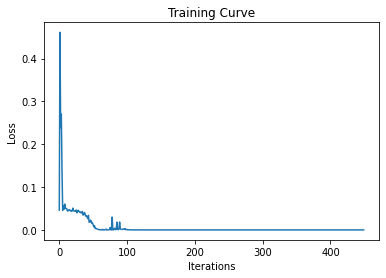

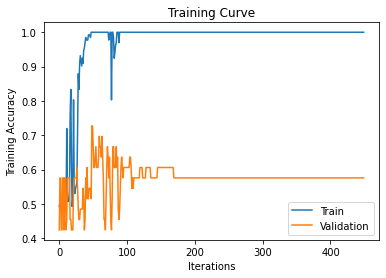

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5757575757575758
Maximum Training Accuracy: 1.0
Maximum Validation Accuracy: 0.7272727272727273


In [46]:
model = CNN_TF()
train(model, train_dataset, val_dataset, batch_size = 15, num_epochs=50, learning_rate = 0.001, momen = 0.7, use_adam = True, save_weights=True)

###### On Wavelet Coefficients Squared

In [47]:
train_dataset = createTensorDataset(X_train_tfp, y_train_tfp)
val_dataset = createTensorDataset(X_val_tfp, y_val_tfp)

#Downsample the height and width to make training easier
train_dataset = downsampleTensorHW(train_dataset, 2)
val_dataset = downsampleTensorHW(val_dataset, 2)

Iteration:  0 | Train Loss:  0.1872564156850179 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  1 | Train Loss:  41.64167887369792 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  2 | Train Loss:  26.25030517578125 | Train Accuracy:  0.49242424242424243 | Validation Accuracy:  0.42424242424242425
Iteration:  3 | Train Loss:  3.2260589599609375 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  4 | Train Loss:  11.641517130533854 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  5 | Train Loss:  8.184124755859376 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.5757575757575758
Iteration:  6 | Train Loss:  3.4310651143391926 | Train Accuracy:  0.5075757575757576 | Validation Accuracy:  0.45454545454545453
Iteration:  7 | Train Loss:  0.7095349629720052 | Train Accuracy:  0.5075757575757576 | Validat

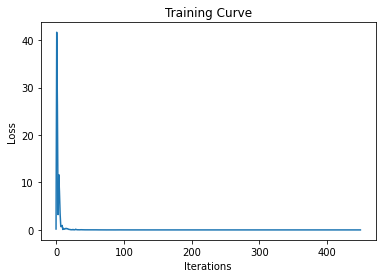

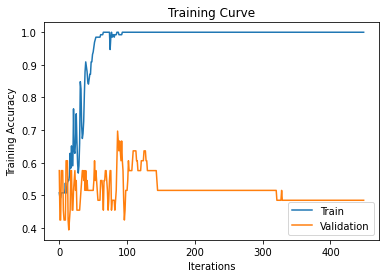

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.48484848484848486
Maximum Training Accuracy: 1.0
Maximum Validation Accuracy: 0.696969696969697


In [48]:
model = CNN_TF()
train(model, train_dataset, val_dataset, batch_size = 15, num_epochs=50, learning_rate = 0.001, momen = 0.7, use_adam = True, save_weights=True)